# Fetching crypto and tweets data.

In [2]:
from sklearn.preprocessing import OrdinalEncoder
from TweetScraper import TweetScraper
from CryptoApi import CryptoApi
import pandas as pd
import numpy as np
import re


# scrp = TweetScraper(start='2023-05-04', end='2023-05-14', maxEmptyPages=2, max_workers=8)
# new_tweets = scrp.parallel_download_tweets()
# new_twt = pd.DataFrame(new_tweets)


# with open('crypto_token.txt','r') as f:
#     token = f.readline()
    
# crypto = CryptoApi(token)
# crypto.get_data('btc','usd','day',period_count=90)

# Analysis of tweets

In [3]:
# new_tweets_df = TweetScraper().fetch_data('2023-04-10','2023-06-09', frequency='d')
# cleaned_df = TweetCleaner().transform(new_tweets_df)
# nlp_model = LDA().fit(cleaned_df)
# cleaned_df = extract_topics(nlp_model.topics)

# new_btc_df = CryptoApi().fetch_data()
# cleaned_btc = CryptoCleaner().transform(new_btc_df)
# xgb_model = XGBoost().fit(cleaned_btc)

In [4]:
from DataPreparation.CryptoPreprocessor import CryptoPreprocessor
from DataPreparation.TweetPreprocessor import TweetPreprocessor
from DataPreparation.TextVectorizer import TextVectorizer
from gensim.test.utils import datapath
from gensim.models import LdaMulticore


tweets_df = pd.read_csv(r'Data/elon_tweets.csv', index_col=0)
twt_prep = TweetPreprocessor(tweets_df)
mod_tweets_df = twt_prep.transform()

text2vec = TextVectorizer()
preprocessing_pipeline = text2vec.make_pipeline()
id2word, corpus = preprocessing_pipeline.transform(mod_tweets_df['rawContent'].values.tolist())

In [5]:
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs


def black_box_function(x, y):
    """Function with unknown internals we wish to maximize.

    This is just serving as an example, for all intents and
    purposes think of the internals of this function, i.e.: the process
    which generates its output values, as unknown.
    """
    return -x ** 2 - (y - 1) ** 2 + 1

def optimize_bayes(func, pbounds=None, verbose=2):
    if pbounds==None:
        pbounds = {'x': (2, 12), 'y': (-15, 15)}
        
    optimizer = BayesianOptimization(
        f=func,
        pbounds=pbounds,
        verbose=verbose, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
        random_state=1,
    )
    # optimizer.maximize(init_points=2,n_iter=3)
            
    # for i, res in enumerate(optimizer.res):
    #     print(f"Iteration {i}:\n{res}")
                
    # optimizer.set_bounds(new_bounds={"x": (-2, 3)})
    optimizer.maximize(init_points=0, n_iter=15)
            
    # optimizer.probe(params={"x": 0.5, "y": 0.7}, lazy=True)
    
    logger = JSONLogger(path="./logs.log")
    optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)
    optimizer.maximize(init_points=2,n_iter=3)

    
# optimize_bayes(func=black_box_function, verbose=2)

In [6]:
new_optimizer = BayesianOptimization(f=black_box_function,
                                     pbounds={"x": (-2, 2), "y": (-2, 2)},
                                     verbose=2,
                                     random_state=7)
print(len(new_optimizer.space))

0


In [7]:
load_logs(new_optimizer, logs=["./logs.log.json"])
print("New optimizer is now aware of {} points.".format(len(new_optimizer.space)))

New optimizer is now aware of 5 points.


In [8]:
# new_optimizer.maximize(
#     init_points=0,
#     n_iter=10,
# )

In [9]:
temp_file = datapath(r"D:\Projects\ElonMuskCrypto\Models\NLPmodels\lda")
lda_model = LdaMulticore.load(temp_file)

btc_df = pd.read_csv('Data/btc_data.csv', index_col=0)
crypto_prep = CryptoPreprocessor()
topics_btc = crypto_prep.transform(lda_model, mod_tweets_df, btc_df)

In [10]:
# import matplotlib.pyplot as plt
# import seaborn as sns


# fig, ax = plt.subplots(figsize=(15,10))
# sns.boxplot(data=topics_btc, x='month',y='open')
# ax.set_title('open by month')

In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score


X = topics_btc.copy()
X["tomorrow"] = X["close"].shift(-1)
X["target"] = (X["tomorrow"] > X["close"]).astype(int)

target = 'target'
predictors = [col for col in X if col not in ['target', 'tomorrow','close']]

tss = TimeSeriesSplit(n_splits=6)
baseline_model = RandomForestClassifier(n_estimators=100, min_samples_split=25, random_state=1, n_jobs=-1)

In [12]:
# horizons = [2,5,10,15,20,25]
horizons = [2,5,60,250]

def add_trend_season(data, horizons):
    predictors = []
    for horizon in horizons:
        rolling_average = data.rolling(horizon).mean()
        
        ratio_column = f'close_ratio{horizon}'
        data[ratio_column] = data['close'] / rolling_average['close']
        
        trend_column = f'Trend_{horizon}'
        data[trend_column] = data.shift(1).rolling(horizon).sum()['target']
        
        predictors += [ratio_column, trend_column]
        
    return predictors


new_predictors = add_trend_season(X, horizons)

In [13]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['target'])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= 0.65] = 1
    preds[preds < 0.65]  = 0
    preds = pd.Series(preds, index=test.index, name='Predictions')    
    combined = pd.concat([test['target'], preds], axis=1)
    
    return combined

def backtest(X, predictors, model):
    all_preds = []
    for (train_idx, test_idx) in tss.split(X):
        train = X.iloc[train_idx]
        test  = X.iloc[test_idx]        
        
        preds = predict(train, test, predictors, model)
        all_preds.append(preds)
        
    return pd.concat(all_preds)


tss = TimeSeriesSplit(n_splits=2)
baseline_model = RandomForestClassifier(n_estimators=100, 
                                        min_samples_split=2, 
                                        random_state=1,
                                        n_jobs=-1)

# preds = backtest(X, predictors, baseline_model)    
preds = backtest(X.dropna(), predictors, baseline_model)    
print(preds['Predictions'].value_counts().values)
precision_score(preds['target'], preds['Predictions'])

[945 105]


0.5238095238095238

In [61]:
topics_btc["tomorrow"] = topics_btc["close"].shift(-1)
topics_btc["target"] = (topics_btc["tomorrow"] > topics_btc["close"]).astype(int)
horizons = [2,5,60,250]

def add_trend_season(data, horizons, ignore_trend=False, ignore_season=False):
    predictors = []
    for horizon in horizons:
        rolling_average = data.rolling(horizon).mean()
        
        if not ignore_trend:
            ratio_column = f'close_ratio{horizon}'
            data[ratio_column] = data['close'] / rolling_average['close']
            predictors += [ratio_column]
            
        if not ignore_season:            
            trend_column = f'Trend_{horizon}'
            data[trend_column] = data.shift(1).rolling(horizon).sum()['target']
            predictors += [trend_column]        
        
    return predictors


# new_predictors = add_trend_season(topics_btc, horizons)

In [17]:
topics_btc["tomorrow"] = topics_btc["close"].shift(-1)
topics_btc["target"] = (topics_btc["tomorrow"] > topics_btc["close"]).astype(int)

In [92]:
import matplotlib.pyplot as plt
from datetime import datetime


xgb = XGBClassifier(n_estimators=150,                     
                    max_leaves=50,
                    learning_rate=0.1,
                    random_state=1,
                    n_jobs=-1)

data = topics_btc.copy()
data = data.reset_index()
data['isPandemic'] = data['date'].apply(lambda x: 1 if (datetime(2020,1,30) <= x) & (x <= datetime(2023,5,5)) else 0)
data['isInvasion'] = data['date'].apply(lambda x: 1 if (x <= datetime.today()) else 0)
data = data.set_index('date')

In [93]:
new_predictors = add_trend_season(data, [2,5,10,20,30,40,50])#+['isInvasion','isPandemic']
test_scores = {}
for i in range(250, 2000, 250):
    train = data.iloc[0:i]
    test  = data.iloc[i:i+250]
    xgb.fit(train[predictors+new_predictors], train['target'])
    test_scores.update({i: precision_score(test[target], xgb.predict(test[predictors+new_predictors]))})

In [56]:
for item in ['T_0', 'T_1', 'T_2', 'T_3', 'T_4', 'T_5', 'T_6','T_7', 'T_8', 'T_9', 'T_10', 'T_11', 'T_12', 'T_13', 'T_14','T_15', 'T_16', 'T_17', 'T_18', 'T_19', 'T_20', 'T_21', 'T_22','T_23', 'T_24']:
    if item in predictors:
        predictors.remove(item)

# Tuning XGB

In [94]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['target'])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= 0.749582] = 1
    preds[preds < 0.749582]  = 0
    
    preds = pd.Series(preds, index=test.index, name='Predictions')    
    combined = pd.concat([test['target'], preds], axis=1)
    return combined

def backtest(X, predictors, model):
    all_preds = []
    for (train_idx, test_idx) in tss.split(X):
        train = X.iloc[train_idx]
        test  = X.iloc[test_idx]        
        
        preds = predict(train, test, predictors, model)
        all_preds.append(preds)
        
    return model, pd.concat(all_preds)

xgb = XGBClassifier(n_estimators=20, 
                    max_depth=4,
                    learning_rate=0.2,
                    random_state=1,
                    n_jobs=-1)


tss = TimeSeriesSplit(n_splits=3)
dummy = data.copy()
horizons = [2,7,14,50,90]
new_predictors = add_trend_season(dummy, horizons)+['isPandemic']

In [95]:
# best_xgb_model, preds = backtest(dummy, predictors+new_predictors, xgb)
# precision = precision_score(preds['target'], preds['Predictions']) # 0.6226415094339622 precision
# str_precision = str(precision).split('.')[1]
# best_xgb_model.save_model(f'Models/CRYPTOmodels/xgb_{str_precision}.json')

In [ ]:
start = '2023-06-10'
end = '2023-06-20'
scrp = TweetScraper(start=start, end=end, max_empty_pages=1, max_workers=8)
new_tweets = scrp.parallel_download_tweets()

with open('crypto_token.txt','r') as f:
    token = f.readline()

crypto = CryptoApi(token)
period_count = (datetime.strptime(end,'%Y-%m-%d')-datetime.strptime(start,'%Y-%m-%d')).days    
new_btc = crypto.fetch_data('btc','usd', period='day', period_count=period_count)

new_tweets = pd.DataFrame(new_tweets)
tweets_df = pd.read_csv(r'Data/elon_tweets.csv', index_col=0)
allowed_cols = [col for col in new_tweets.columns if col in tweets_df.columns]
new_tweets = new_tweets[allowed_cols].copy()


twt_prep = TweetPreprocessor(new_tweets)
mod_tweets_df = twt_prep.transform()
text2vec = TextVectorizer()
preprocessing_pipeline = text2vec.make_pipeline()
id2word, corpus = preprocessing_pipeline.transform(mod_tweets_df['rawContent'].values.tolist())

temp_file = datapath(r"D:\Projects\ElonMuskCrypto\Models\NLPmodels\lda")
lda_model = LdaMulticore.load(temp_file)
crypto_prep = CryptoPreprocessor()
new_topics_btc = crypto_prep.transform(lda_model, mod_tweets_df, new_btc)

xgb_model = XGBClassifier()
xgb_model.load_model('Models/CRYPTOmodels/xgb_6226415094339622.json')

allowed_predictors = new_topics_btc[xgb_model.feature_names_in_].copy()
predictions = xgb_model.predict(allowed_predictors)

# Predicting new data pipeline

In [171]:
# values set by a user
start = '2023-06-10'
end = '2023-06-20'

scrp = TweetScraper(start=start, end=end, max_empty_pages=1, max_workers=8)
new_tweets = scrp.parallel_download_tweets()

with open('crypto_token.txt','r') as f:
    token = f.readline()

period_count = (datetime.strptime(end,'%Y-%m-%d')-datetime.strptime(start,'%Y-%m-%d')).days    
crypto = CryptoApi(token)
new_btc = crypto.fetch_data('btc','usd', period='day', period_count=period_count)

new_tweets = pd.DataFrame(new_tweets)
tweets_df = pd.read_csv(r'Data/elon_tweets.csv', index_col=0)
allowed_cols = [col for col in new_tweets.columns if col in tweets_df.columns]
new_tweets = new_tweets[allowed_cols].copy()


twt_prep = TweetPreprocessor(new_tweets)
mod_tweets_df = twt_prep.transform()


# why tf do i need it? for updating my NLP model
text2vec = TextVectorizer()
preprocessing_pipeline = text2vec.make_pipeline()
id2word, corpus = preprocessing_pipeline.transform(mod_tweets_df['rawContent'].values.tolist())


temp_file = datapath(r"D:\Projects\ElonMuskCrypto\Models\NLPmodels\lda")
lda_model = LdaMulticore.load(temp_file)

Stopping after 1 empty pages
Stopping after 1 empty pages
Stopping after 1 empty pages
Stopping after 1 empty pages
Stopping after 1 empty pages
Stopping after 1 empty pages
Stopping after 1 empty pages
Stopping after 1 empty pages
Stopping after 1 empty pages
Stopping after 1 empty pages


In [172]:
crypto_prep = CryptoPreprocessor()
new_topics_btc = crypto_prep.transform(lda_model, mod_tweets_df, new_btc)

In [173]:
xgb_model = XGBClassifier()
xgb_model.load_model('Models/CRYPTOmodels/xgb_6226415094339622.json')

new_topics_btc["tomorrow"] = new_topics_btc["close"].shift(-1)
new_topics_btc["target"] = (new_topics_btc["tomorrow"] > new_topics_btc["close"]).astype(int)
new_topics_btc = new_topics_btc.reset_index()
new_topics_btc['isPandemic'] = new_topics_btc['date'].apply(lambda x: 1 if (datetime(2020,1,30) <= x) & (x <= datetime(2023,5,5)) else 0)
new_topics_btc = new_topics_btc.set_index('date')

horizons = [2,7,14,50,90]
new_predictors = add_trend_season(new_topics_btc, horizons)+['isPandemic']
predict_data = new_topics_btc[xgb_model.feature_names_in_].copy()


predictions = xgb_model.predict(predict_data)
precision_score(new_topics_btc['target'], predictions)

0.5

In [23]:
# fig, ax1 = plt.subplots(1)
# fig.set_figwidth(20)
# fig.set_figheight(10)

# dummy = data.copy()
# horizons = [2,7,14,50,90]
# new_predictors = add_trend_season(dummy, horizons)+['isPandemic']

# for days in range(30,210,30):
#     xgb = XGBClassifier(n_estimators=40, 
#                         max_depth=4,
#                         learning_rate=0.1,
#                         random_state=1,
#                         n_jobs=-1)
    
#     test_scores  = {}
#     train_scores = {} 

#     for i in range(0, 2000, days):
#         train = dummy.iloc[0:i]
#         test  = dummy.iloc[i:i+days]
#         xgb.fit(train[predictors+new_predictors], train['target'])
#         test_scores.update({i: precision_score(test[target], xgb.predict(test[predictors+new_predictors]))})
#         train_scores.update({i: precision_score(train[target], xgb.predict(train[predictors+new_predictors]))})

#     ax1.plot(test_scores.keys(), test_scores.values(), label=f'{days}')
#     ax1.scatter(test_scores.keys(), test_scores.values())
#     ax1.axhline(0.5, c='red')
#     ax1.grid(axis='y')
#     ax1.legend()

#     mean_test_accuracy = np.mean(list(test_scores.values()))
#     mean_train_accuracy = np.mean(list(train_scores.values()))
#     std_accuracy  = np.std(list(test_scores.values()))
#     print(f'{days} = {round(mean_test_accuracy, 5):<6} | {round(mean_train_accuracy, 5):<6} | {round(std_accuracy, 5)}')
    
# plt.show()

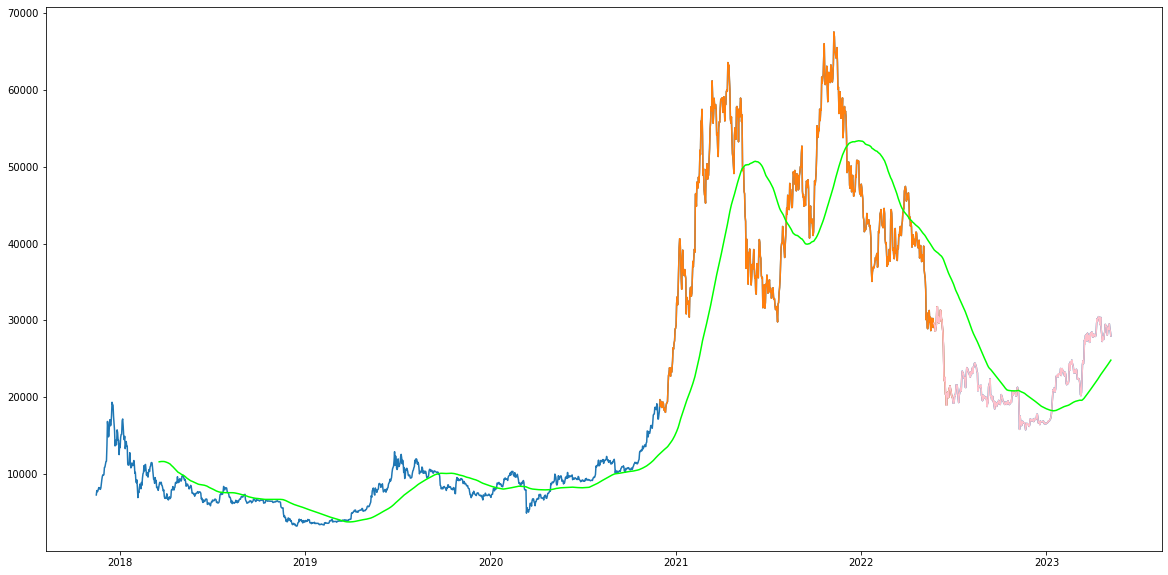

In [24]:
plt.figure(figsize=(20,10))
plt.plot(data['close'])
plt.plot(data[(datetime(2020,11,30) <= data.index) & (data.index <= datetime(2022,6,30))]['close'])
# plt.plot(data[(datetime(2023,2,24) <= data.index) & (data.index <= datetime.today())]['close'], c='purple')
plt.plot(data['close'].iloc[-350:], c='pink')


plt.plot(data['close'].rolling(125).mean(), color='lime')

# add columns for "crypto boom"

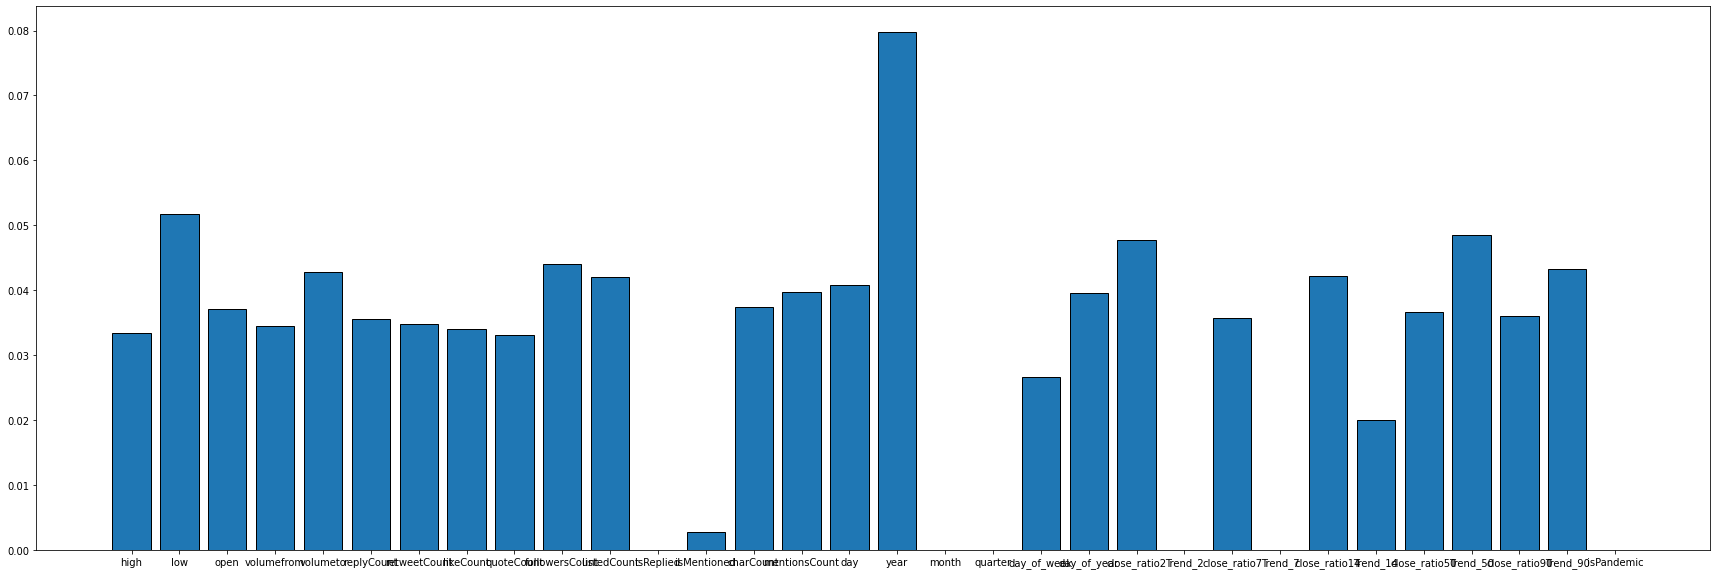

In [25]:
plt.figure(figsize=(30,10))
df = pd.DataFrame(zip(xgb.feature_names_in_, xgb.feature_importances_))


plt.bar(df[0], df[1], edgecolor='black')
# plt.margins(0,0)
plt.show()

In [26]:
eth_df = pd.read_csv('Data/eth_data.csv')
eth_df = eth_df.rename(columns={'time':'date'}).drop(['Unnamed: 0','conversionType','conversionSymbol'], axis=1)
eth_df['date'] = eth_df['date'].apply(lambda x: datetime.fromtimestamp(x))
eth_df = eth_df.set_index('date')


doge_df = pd.read_csv('Data/doge_data.csv')
doge_df = doge_df.rename(columns={'time':'date'}).drop(['Unnamed: 0','conversionType','conversionSymbol'], axis=1)
doge_df['date'] = doge_df['date'].apply(lambda x: datetime.fromtimestamp(x))
doge_df = doge_df.set_index('date')

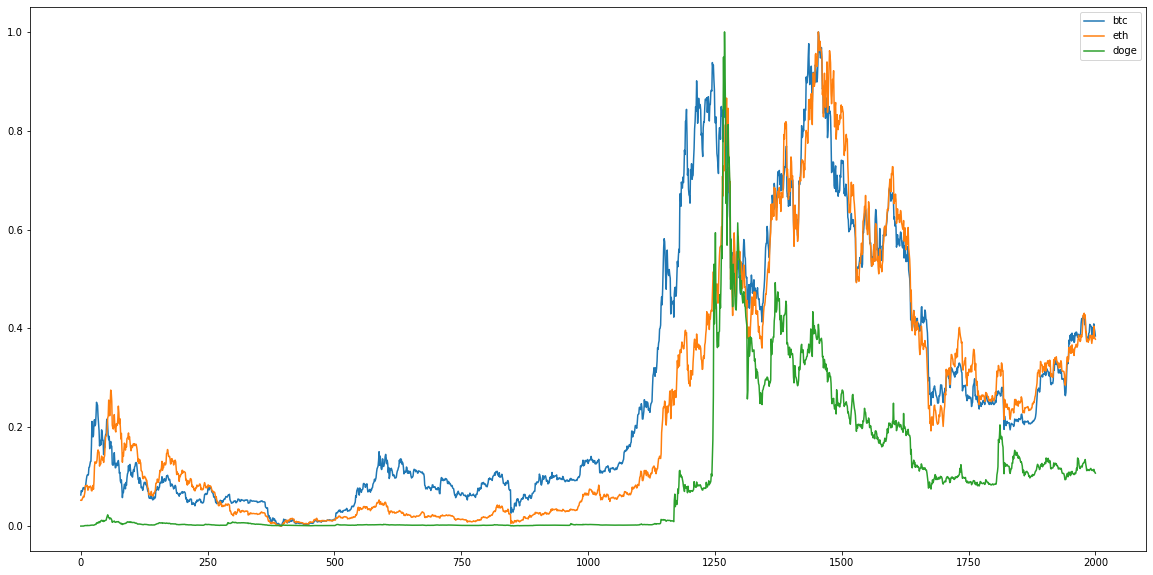

In [27]:
from sklearn.preprocessing import MinMaxScaler



plt.figure(figsize=(20,10))

for crypto, name in zip([topics_btc, eth_df, doge_df], ['btc','eth','doge']):
    scaler = MinMaxScaler()
    data = scaler.fit_transform(crypto['close'].values.reshape(-1, 1))    
    plt.plot(data, label=name)
    
plt.legend()

In [28]:
# from sklearn.preprocessing import MinMaxScaler


# train_data = btc_df[:400].copy()

# scaler = MinMaxScaler(feature_range=(0,1))
# scaled_data = scaler.fit_transform(train_data['close'].values.reshape(-1,1))


# prediction_days = 60
# x_train = []
# y_train = []
# for x in range(prediction_days, len(scaled_data)):
#     x_train.append(scaled_data[x-prediction_days:x, 0])
#     y_train.append(scaled_data[x, 0])
    
# x_train, y_train = np.array(x_train), np.array(y_train)
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


# test_data = btc_df[400:].copy()
# total_dataset = pd.concat((btc_df['close'], test_data['close']))

# model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
# model_inputs = model_inputs.reshape(-1,1)
# model_inputs = scaler.transform(model_inputs)

# X_test = []
# for x in range(prediction_days, len(model_inputs)):
#     X_test.append(model_inputs[x-prediction_days:x, 0])

In [29]:
# (data['target'].value_counts()/len(data)).values

In [30]:
#TODO: make tracker for features that were dropped due to high sparsity in case of leaving threshold of 50% sparsity
# for future model upgrading and adding new features.